In [1]:
import torch
import numpy as np
import os
import glob
import segmentation_models_pytorch as smp
import rasterio
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torch import nn
from modules import STACDataset
from pytorch_toolbelt.inference import tta
import matplotlib.pyplot as plt
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [2]:
class Ensembler(nn.Module):
    def __init__(self, models):
        super().__init__()
        self.models = nn.ModuleList(models)
        
    def forward(self, inp):
        
        outputs = [model(inp) for model in self.models]
        outputs = torch.stack(outputs, dim=0)
        #return harmonic_mean(outputs)
        return outputs.mean(dim=0)

In [3]:
def setup(encoder_name, decoder_name, supplementary):
    if supplementary:
        in_channels=7
    else:
        in_channels=3
    model = getattr(smp, decoder_name)(encoder_name, in_channels=in_channels, activation=None, encoder_weights=None).cuda()
    return model

def parse(path):
    name = path.split('/')[-1]
    encoder_name, decoder_name = name.split('.')[0:2]
    return encoder_name, decoder_name

def threshold(img, threshold=0.5):
    thresholded = (img >= threshold).astype('uint8')
    return thresholded

def create_model(model_paths, supplementary):
    
    models = []
    for path in model_paths:
        ckpt = torch.load(path)
        encoder_name, decoder_name = parse(path)
        model = setup(encoder_name, decoder_name, supplementary)
        model.load_state_dict(ckpt['model'])
        models.append(model)
    model = Ensembler(models)
    return model

In [4]:
def read_img_and_mask(fp):
    with rasterio.open(fp) as f:
        masked_arr = f.read(1, masked=True)
        data = masked_arr.data
        mask = masked_arr.mask
    return data, mask


def img2tensor(img,dtype:np.dtype=np.float32):
    if img.ndim==2 : img = np.expand_dims(img,-1)
    img = np.transpose(img,(2,0,1))
    return torch.from_numpy(img.astype(dtype, copy=False))


class STACDataset(Dataset):
    def __init__(self, data_path, labels_path, supplementary=False, tfms=None):
        self.ids = [fname[:5] for fname in os.listdir(labels_path)]
        self.labels_path = labels_path
        self.data_path = data_path
        self.tfms = tfms
        self.supplementary = supplementary
        
    def __len__(self):
        return len(self.ids)
    
    def __getitem__(self, idx):
        sample_id = self.ids[idx]
        
        fp_vv = os.path.join(self.data_path,sample_id+'_vv.tif')
        img_vv, mask_vv = read_img_and_mask(fp_vv)
        
        fp_vh = os.path.join(self.data_path,sample_id+'_vh.tif')
        img_vh, mask_vh = read_img_and_mask(fp_vh)
        
        fp_target = os.path.join(self.labels_path, sample_id+'.tif')
        target, mask_target = read_img_and_mask(fp_target)
        
        img = np.stack([img_vv, img_vh], axis=-1)
        
        #norm
        min_norm = -77
        max_norm = 26
        img = np.clip(img, min_norm, max_norm)
        img = (img - min_norm) / (max_norm - min_norm)
        
        product = (img_vv**2)*(img_vh**2)
        product = np.ma.masked_array(product, mask_vv | mask_vh)
        min_product = product.min()
        product = (product - min_product) / (product.max() - min_product)
        product = np.expand_dims(product, -1)
        img = np.concatenate([img, product.data], axis=-1)
        
        if self.supplementary:
            supplementary = filter(
                lambda path: ('vv' not in path) and ('vh' not in path) and ('nasadem' not in path) and ('change' not in path),
                glob.glob(os.path.join(self.data_path, sample_id+'*.tif'))
            )
            
            sup_imgs = []
            for path in supplementary:
                img_, mask_ = read_img_and_mask(path)
                sup_imgs.append(img_)
            
            sup_imgs = np.stack(sup_imgs, axis=-1)
            sup_imgs = sup_imgs / 255.0
            
            img = np.concatenate([img, sup_imgs.astype('float32')], axis=-1)
        
        if self.tfms is not None:
            augmented = self.tfms(image=img,mask=target)
            img, target = augmented['image'],augmented['mask']
            
        return img2tensor(img), img2tensor(target)

In [5]:
def harmonic_mean(inp):
    n = len(inp)
    inverted = inp.pow(-1.0)
    hm = n / torch.sum(inverted, dim=0)
    return hm

In [7]:
def IandU(pred, targ, threshold=0.5):
    pred_bin = pred>threshold
    targ_bin = targ>threshold
    
    intersection = torch.sum((pred_bin*targ_bin)>0).item()
    union = torch.sum((pred_bin+targ_bin)>0).item()
    
    return intersection, union

In [15]:
supplementary = False
model_paths = filter(lambda path: 'last' not in path,glob.glob('/storage1/iigor/drivendata/STAC_flood/checkpoints/STAC-175/*.pth'))
model = create_model(model_paths, supplementary=supplementary)
model.eval()
model.cuda();

In [16]:
dataset_train = STACDataset(
    data_path='/storage1/nerusskikh/drivendata/STAC_flood/data/train_features/',
    labels_path='/storage1/nerusskikh/drivendata/STAC_flood/data/train_labels/',
    supplementary=supplementary
)
dataloader = DataLoader(dataset_train, batch_size=16, shuffle=False, drop_last=False, num_workers=8)

In [17]:
preds = []
targets = []

sigmoid = nn.Sigmoid()
with torch.no_grad():
    for step, (input_, target_)  in tqdm(enumerate(dataloader), total=len(dataloader), ncols=100, leave=False):
        input_ = input_.cuda()
        target_ = target_.cuda()
        
        if tta:
            out_ = tta.d4_image2mask(model, input_)
        else:
            out_ = model(input_)
        
        mask = (target_ != 255) 
        target_ = target_*mask   
        out_ = out_*mask
        out_ = sigmoid(out_)
        
        preds.append(out_.detach().cpu())
        targets.append(target_.detach().cpu())

In [18]:
thresholds = np.arange(0,1,0.01)
scores = []
for th in thresholds:
    
    val_intersections = []
    val_unions = []
    
    for out_, target_ in zip(preds,targets):
        i_, u_ = IandU(out_, target_, threshold = th)
        val_intersections.append(i_)
        val_unions.append(u_)
        
    aggregated_metric = np.sum(val_intersections)/(np.sum(val_unions)+1e-8)
    scores.append(aggregated_metric)

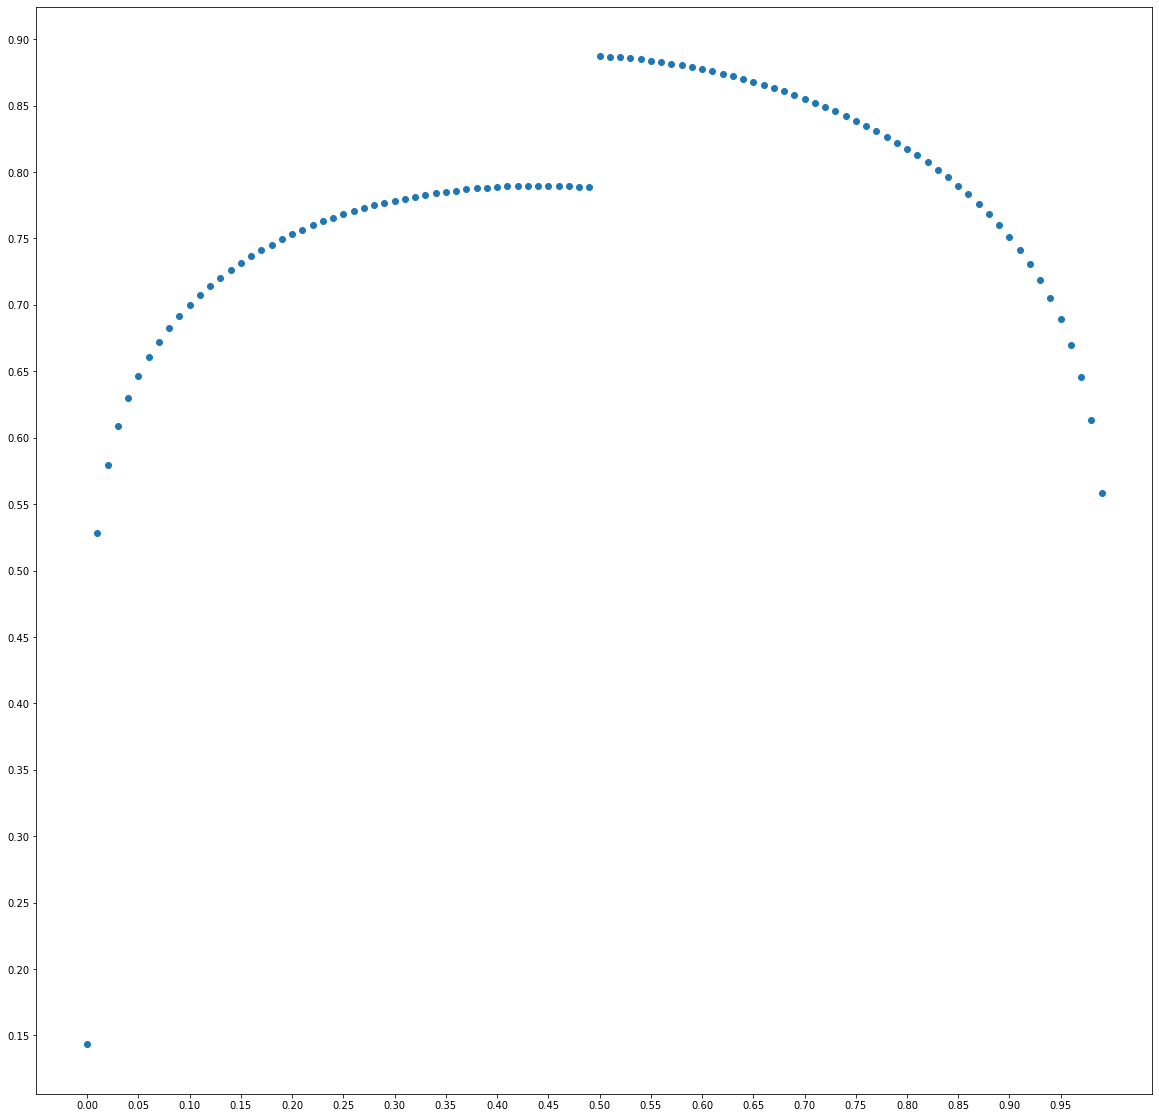

In [19]:
figure = plt.figure(figsize=(20,20))
plt.xticks(np.arange(0,1,0.05))
plt.yticks(np.arange(0,1,0.05))
plt.scatter(thresholds, scores)#, '-')

In [20]:
thresholds[np.argmax(scores)]

0.5

In [21]:
np.max(scores)

0.8873265882618019

In [60]:
for sc, th in zip(scores,thresholds):
    print(sc,th)

0.14328370323040387 0.0
0.37838438090834436 0.01
0.4655008728443151 0.02
0.5157172261673159 0.03
0.5504814461390203 0.04
0.5765474834307068 0.05
0.5972207589264023 0.06
0.6143260418975232 0.07
0.6287982999722672 0.08
0.6413828296804913 0.09
0.6524931188274598 0.1
0.6624011839504166 0.11
0.6713178898567161 0.12
0.6793685091869055 0.13
0.6867138148956745 0.14
0.693462269920312 0.15
0.6996473276400277 0.16
0.7053730484623751 0.17
0.7106642955903723 0.18
0.7155723509003864 0.19
0.7201140771645964 0.2
0.7243027426147239 0.21
0.7282325446997734 0.22
0.7319284120979934 0.23
0.735388590355131 0.24
0.7386552331079852 0.25
0.7417169917688792 0.26
0.7446226578807772 0.27
0.747318649579597 0.28
0.7498226650205918 0.29
0.7521703124831873 0.3
0.7543662284778659 0.31
0.7564318036911236 0.32
0.7583572088109269 0.33
0.7601247192187478 0.34
0.7618032255983259 0.35000000000000003
0.7633342418790955 0.36
0.7647547964136945 0.37
0.7660503452495894 0.38
0.7672255190385332 0.39
0.7682726385392337 0.4
0.76921